In [1]:
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('..')
sys.path.append('../../lung_cancer/radio/')

DIR_CANCER = 'C:/projects/lung_cancer/data/lunaset_split/train/cancer/*'
DIR_NCANCER = 'C:/projects/lung_cancer/data/lunaset_split/train/ncancer/*'

NODULES = pd.read_csv('C:/projects/lung_cancer/data/CSVFILES/annotations.csv')
TEST = 'C:/projects/lung_cancer/data/subset*/*.mhd'

In [3]:
import radio
from radio import dataset as ds
from radio import CTImagesMaskedBatch as CTIMB
from radio.dataset import V, F, C, Pipeline
from radio.pipelines import combine_crops
from radio.dataset.models.tf import VNet
from radio.models.tf.losses import tversky_loss_with_logits, bce_with_logits, bce
import tensorflow as tf
from radio.experiments.utils import get_test_pipeline, get_train_pipeline

# from utils import InteractivePlot

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [4]:
from radio.dataset.research import Research, Option

In [5]:
cix = ds.FilesIndex(path=DIR_CANCER, dirs=True)
ncix = ds.FilesIndex(path=DIR_NCANCER, dirs=True)

cancerset = ds.Dataset(index=cix, batch_class=CTIMB)
ncancerset = ds.Dataset(index=ncix, batch_class=CTIMB)

In [6]:
cancerset.cv_split()
ncancerset.cv_split()

In [7]:
model_config = {
    'inputs': {
        'images/shape': (32, 64, 64, 1),
        'labels': {'name': 'targets', 'shape': (32, 64, 64, 1)}
    },
    'loss': bce, # tversky_loss_with_logits, #'softmax_cross_entropy', #
    'optimizer': 'Adam',
    'input_block/inputs': 'images',
    'head/kernel_size': 1,
    'head/num_classes': 1,
    'head/layout': 'ca',
    'head/activation': tf.sigmoid,
    #'output/ops': 'sigmoid'
}

# preproc = Pipeline().mix_images(p=0.75, mode=C('mode'), mix_masks=C('mix_masks'))
preproc = Pipeline().mix_images(p=0.75, mode='max', mix_masks=True)

In [8]:
from radio import CTImagesMaskedBatch

test_index = ds.FilesIndex(path=TEST, no_ext=True)
test_ds = ds.Dataset(index=test_index, batch_class=CTImagesMaskedBatch)

In [9]:
train_ppl = get_train_pipeline(cancerset, ncancerset, VNet, preproc)
train_ppl.set_config({'model_config': model_config})

In [10]:
train_ppl.next_batch()

In [11]:
# test_ppl = (test_ds.p
#             .import_model('model', train_ppl)
#             .load(fmt='raw')
#             .unify_spacing(spacing=(1.7, 1.0, 1.0),
#                            shape=(400, 512, 512),
#                            method='pil-simd',
#                            padding='reflect')
#             .normalize_hu()
#             .resize(shape=(100, 100, 100))
#             .predict_on_scan(model_name='model',
#                              strides=(32, 64, 64),
#                              crop_shape=(32, 64, 64),
#                              batch_size=4,
#                              show_progress=True)
#            )

In [12]:
test_ppl = get_test_pipeline(NODULES, test_ds)
test_ppl.set_config({'model_config': model_config, 'train_pipeline': train_ppl})

In [22]:
batch = test_ppl.next_batch()

In [14]:
from radio.experiments.utils import compute_test_metrics

In [15]:
test_ppl.get_variable('true_stats')

[]

In [16]:
len(test_ppl.get_variable('true_stats'))

0

In [23]:
compute_test_metrics(batch, NODULES)

In [24]:
np.in1d(batch.indices, NODULES.seriesuid)

array([ True,  True], dtype=bool)

In [26]:
NODULES.seriesuid

0       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
1       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
2       1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...
3       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
4       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
5       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
6       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
7       1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...
8       1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...
9       1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...
10      1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985...
11      1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...
12      1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...
13      1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...
14      1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085...
15      1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...
16      1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...
17      1.3.6.

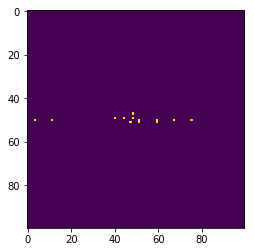

In [27]:
import matplotlib.pyplot as plt

plt.imshow(batch.data.masks[16])
plt.show()

In [16]:
# train_ppl.set_config({'model_config': model_config})
# for i in range(10):
#     train_ppl.next_batch()

In [24]:
# import matplotlib.pyplot as plt

# plt.plot(train_ppl.get_variable('loss'))
# plt.show()

In [18]:
# train_ppl = (
#     combine_crops(cancerset.train, ncancerset.train, batch_sizes=(2, 2))
#     .mix_images(p=0.75, mode=C('mode'), mix_masks=C('mix_masks'))
#     .init_variable('loss', init_on_each_run=list)
#     .init_model(
#         name='model', model_class=VNet,
#         config=model_config, mode='dynamic'
#     )
#     .train_model(
#         name='model', fetches='loss', save_to=V('loss'), mode='a',
#         feed_dict={'images': F(CTIMB.unpack, component='images'),
#                    'targets': F(CTIMB.unpack, component='masks')}
#     )
# )

In [19]:
# test_ppl = (
#     combine_crops(cancerset.test, ncancerset.test, batch_sizes=(2, 2))
#     .init_variable('proba', init_on_each_run=list)
#     .import_model('model', C('import_from'))
#     .predict_model(
#         name='model', fetches='output_sigmoid', save_to=V('proba'), mode='a',
#         feed_dict={'images': F(CTIMB.unpack, component='images'),
#                    'targets': F(CTIMB.unpack, component='masks')}
#     )
# )

In [20]:
# op1 = Option('mode', ['max', 'none'])
# op2 = Option('mix_masks', [True, False])
# op3 = Option('loss', [tversky_loss_with_logits, ])

In [21]:
# from radio.dataset.research import SavingWorker

In [22]:
# research = Research()
# research.add_pipeline(train_ppl, 'loss', name='train',)
# research.add_grid_config(op1 * op2)
# research.run(1, 5000, n_jobs=[SavingWorker('Custom')])